### Introduction

sbmOpenMM is a python library which facilitates setting up simulations of structure based models (SBMs), for protein systems, using the molecular dynamics (MD) framework of OpenMM. Essentially, the library reads a PDB file and creates a force field in which the input structure is defined as the global energy minimum in the potential energy function. These kind of force fields are referred to as topology-based, because, the interactions in it do not depend on the details of the chemical composition of the system, but only on the structures’ connectivities and geometries.

Creating a simulation is as simple as importing the library and calling the SBM model to be used to represent the system. Mainly, two models are widely used depending on the atomic details you want to use. One of the faster and optimal method is a coarse-grained representation of the residues in the protein, in which each residue is replaced by one bead centered in each alpha-carbon atom. The model is referred as the CA model and the details of the force field can be read here. Here we review how to set up a simple simulation using the CA model, we review in a different section setting up an all-atom simulation. 

### Requirements 

- [OpenMM python API](http://openmm.org/)
- [bmOpenMM library](https://bitbucket.org/compbiochbiophlab/sbm-openmm/src)
- [MDTraj library](http://mdtraj.org/)
- [Numpy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/)

### Coarse grained SBM simulations - The alpha-carbon (CA) model

Briefly, in the CA model, all the alpha-carbon beads in one chain are bonded together by an harmonic potential, using the input structural distances (i.e bond lengths) as the equilibrium distances. The same idea is applied to keep the beads' angles. The torsional dihedral angles between the beads are also biased to adopt the configuration in the input structure, but through the use of a periodic torsion potential. The non-bonded interactions are modeled with special Lennard-Jones (LJ) potentials. On one hand, the native contacts defined for the target structure are maintained through a 12-10 LJ potential, which, in contrast to a typical (12-6) LJ, helps to limit interactions between the beads that would occur at very long distances. Finally, all non-native interactions (i.e. any interaction between the beads that is not a native contact nor a bonded one), are kept only as excluded volume interactions to avoid the self-crossing of the polypetide chains. This is accomplished by using only the repulsive term (12 exponent) of the the LJ potential.

The sbmOpenMM library contains a model class in which default force fields can be loaded easily. But, in order to load any model from it, we first need 2 input files:

1) An input PDB: The PDB file must contain the structure of the protein system to simulate, always considering that the different chains of the proteins are continuous (i.e. not missing internal residues) and do not contain ligands or solvent molecules (just the protein atoms).

2) A contact file: The file contains the pair of indexes of the atoms forming native interactions, which are present in the target (native) configuration.

Having the files available and in order to use the CA model for our protein system, we need first to import the sbmOpenMM library together with the [OpenMM python API](http://docs.openmm.org/development/api-python/index.html)

In [1]:
#Import OpenMM library
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *

#Import sbmOpenMM library
import sbmOpenMM

In this tutorial we will use a PDB and contact file provided in the input folder of this tutorial. The protein file was modified from the [1YPA.pdb](https://www.rcsb.org/structure/1YPA) file and contains residues 22-84 of the subtilisin-chymotrypsin inhibitor-2A. The contact file was generated using the [SMOG2](http://smog-server.org/smog2/) program using the pdb file as input.

In [2]:
#Set the input locations as variables.
pdb_file = 'inputs/1YPA_I.pdb'
contact_file = 'inputs/1YPA_I_CA.contacts'

We load this two files into the sbmOpenMM.models.getCAModel() method to instantiate the sbmOpenMM.system class with default parameters for the CA model. This oject contains all the necessary information to simulate our system with openMM.

It is important to note that the contact file has atom indexes associated with a configuration containing only CA atoms. For this reason it does not match the full-atom pdb file's numbering. If the files are compatible in terms of the number of residues (i.e. CA atoms) sbmOpenMM.models.getCAModel() will preserve only the CA atoms from the input pdb file. 

In [3]:
#Create an sbmOpenMM.system() object and store it in "sbmCAModelModel" variable. 
sbmCAModel = sbmOpenMM.models.getCAModel(pdb_file, contact_file)

Generating CA SBM for PDB file inputs/1YPA_I.pdb

Setting up geometrical parameters:
_________________________________
Keeping only carbon alpha atoms in topology
Added 64 CA atoms
Added 63 bonds
Added 62 angles
Added 61 torsions
Reading contacts from contact file: inputs/1YPA_I_CA.contacts
Added 164 native contacts

Setting up default forcefield parameters:
________________________________________
Adding default bond parameters:
Adding default angle parameters:
Adding default torsion parameters:
Adding default contact parameters:

Adding Forces:
_____________
Added Harmonic Bond Forces
Added Harmonic Angle Forces
Added Periodic Torsion Forces
Added Lennard Jones 12-10 Forces to native contacts
Added Lennard Jones 12 non-bonded Forces

Creating System Object:
______________________
The Potential Energy of the system is : -160.6621551513672 kJ/mol
The Harmonic Bond Energy is: 1.4299672557172016e-09 kj/mol
The Harmonic Angle Energy is: 3.439026841078885e-11 kj/mol
The Periodic Torsion En

We can use the output to follow the steps that were executed to create the sbmOpenMM system object. First, the input pdb is read and an OpenMM topology object is created from it. After this, only alpha-carbon atoms are kept and all their bonds, angles and torsions values are caculated and stored. The contact file is also read and the pairs defined inside are added as native contacts. Then, the method adds the default parameters and forces for the specified model (CA in this case) and, finally, it creates an openmm.system object. All the parameters created are stored inside the attributes of the sbmOpenMM.system() object (sbmCAModel in our case). 

In the last printed output we can see the potential energy details of the input configuration given the newly created SBM force field. Note that most of the energy terms in the force field are zero, except for the non-bonded terms. The LJ 12-10 term is negative, because it reflects the favorable native contact interactions. On the other hand, the LJ 12 term is positive because it represents the repulsion force accounting for the excuded volume of the beads. Remember that in this model all the beads radii are equal and arbitrarily selected (for more details see).  

Now that we have succesfully created our SBM model we can simulate it using OpenMM. For this we are going to employ a [Langevin Integrator](http://docs.openmm.org/development/api-python/generated/simtk.openmm.openmm.LangevinIntegrator.html) with a friction coefficient of 1 $ps^{−1}$, an arbitrary temperature of 100 reduced-temperature-units (RTU) and a timestep of 0.5 $fs$.

In [4]:
#Define integrator and context for the simulation
integrator = LangevinIntegrator(100, 1/picosecond, 0.5*femtoseconds)
simulation = Simulation(sbmCAModel.topology, sbmCAModel.system, integrator)

We also have to create a simulation context, which is initilised with an OpenMM topology, system and integrator. The first two are stored as attributes in our "sbmCAModel" object. Finally, we give the initial positions of our system to this newly created OpenMM context:

In [5]:
#Set initial positions
simulation.context.setPositions(sbmCAModel.positions)

Before running the simulation we would like to set up the storing of the output information into files. This makes it easier to analyse the simulations later using separate scripts. In OpenMM this is controlled passing reporters to the OpenMM simulation object. We will create at least two reporters for running the SBM simulation. 

First, we add a DCD reporter which allows us to write a binary trajectory file containing the coordinates of the simulation every a specified number steps.

In [6]:
#Add a DCD reporter that writes coordinates every 100 steps.
simulation.reporters.append(DCDReporter('traj.dcd', 100))

Then, we will add a special reporter that will allow us to easily print all the energy terms in our SBM force field into a file:

In [7]:
#Add a SBM reporter that writes energies every 100 steps.
simulation.reporters.append(sbmOpenMM.sbmReporter('energy.data', 100, sbmObject=sbmCAModel,
                                                  step=True, potentialEnergy=True, temperature=True))

Note that this reporter is a special version of the [StateDataReporter](http://docs.openmm.org/7.0.0/api-python/generated/simtk.openmm.app.statedatareporter.StateDataReporter.html) class in OpenMM, which additionally takes the SBM object as a keyword argument. When the SBM object is given, the reporter additionally prints all the energy terms of the SBM force field into the reporter file.

Optionally, we can make this reporter to print the energies as standard output for visualising it while we run the script:

In [8]:
from sys import stdout
#Add a SBM reporter that prints energies every 100 steps.
simulation.reporters.append(sbmOpenMM.sbmReporter(stdout, 100, sbmObject=sbmCAModel,
                                                  step=True, potentialEnergy=True, temperature=True))

Now we can proceed with the molecular simulation. We will run the system and follow its trajectory during 2M steps (1 ns) of MD.

In [9]:
import time

print('Simulation started')
start_time = time.time()
for i in range(20000):
    simulation.step(100)
print("--- Finished in %s seconds ---" % ((time.time() - start_time)))

Simulation started
--- Finished in 75.63046455383301 seconds ---


The simulation finished in approximately a minute using a laptop computer with a GeForce GTX 1050 Mobile GPU. This acceleration is due to the scaling capabilities of OpenMM using GPUs and to the high coarse graining  of the forcefield employed. However, it is important to note that 1 $ns$ simulation using an SBM model is not directly comparable to the same amount of time in a more detailed force field (e.g. fully solvated system, electrostatics, etc.). Always take into account the simplifications made by the model when interpreting the data generated by it. 

When running the simulation two files should have been written to the system, the energy file, "energy.data", and the trajectory file, "traj.dcd". These files should be mostly all you will need to analyse the molecular simulation and start making sense of your system. There are many python libraries you can use to analyse simulations in a very straightforward way. Here, we will use [mdtraj](http://mdtraj.org/) to show a couple plots from our short example simulation.

We import mdtraj, matplotlib and numpy:

In [10]:
import mdtraj as md
import matplotlib.pyplot as plt
import numpy as np

In [11]:
energy_file = 'energy.data'
trajectory_file = 'traj.dcd'

First, we will plot the total potential energy to visualise the energetical progression of our system:

Average : -72.7867 kj/mol
Standard deviation : 9.7172 kj/mol


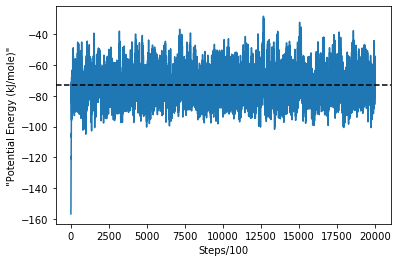

In [15]:
#Create a list to store the energy values
potentialEnergy = []
#Read the energy files and save the lines into a variable
with open(energy_file) as ef:
    lines = ef.readlines()
    #Read the header from the second comma separated value of the first line
    header = lines[0].split(',')[1]
    #Iterate over all but the first line to extract the potential energy values
    for line in lines[1:]:
        potentialEnergy.append(float(line.split(',')[1]))
        
#Plot the potential energy
plt.plot(potentialEnergy)
plt.xlabel('Steps/100')
plt.ylabel(header)
plt.axhline(np.average(potentialEnergy), c='k', ls='--')
print('Average : %.4f kj/mol' % np.average(potentialEnergy))
print('Standard deviation : %.4f kj/mol' % np.std(potentialEnergy))

We see that at 100 RTU the potential energy rises quickly until reaching an approximate average of -72 kj/mol and stays stable around that average with a standard deviation of approximately 10 kj/mol.

Next, we will plot the root mean squared (RMSD) deviation of the simulation with reference to the input structure. For this we will need a PDB that only contains the atoms in the simulated system. The sbmOpenMM library has a method for writing a pdb file containing just that:

In [13]:
sbmCAModel.dumpPdb('input.pdb')

Using mdtraj we now load the input configuration together with the trajectory, we calculate the RMSD and we plot it with matplotlib.

Text(0, 0.5, 'RMSD [$\\AA$]')

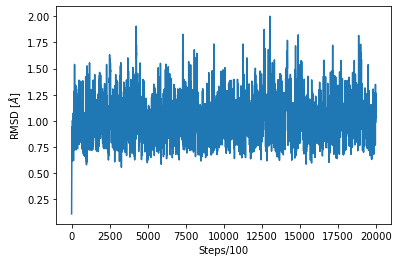

In [14]:
#Load input.pdb as the reference structure
reference = md.load('input.pdb')
#Load input.pdb as the toplogy and traj.dcd as the trajectory file
trajectory = md.load('traj.dcd', top='input.pdb')
#Calculate the rmsd
rmsd = md.rmsd(trajectory, reference)*10 #Convert from nm to angstroms
#Plot the RMSD
plt.plot(rmsd)
plt.xlabel('Steps/100')
plt.ylabel('RMSD [$\AA$]')

We notice that the simulation is stable and that the system maintains its initial configuration, as it would be expected being the global energy minimum conformation by definition.

### Summary

We have used sbmOpenMM library to generate a simulation with the default SBM CA model. The library took only two inputs to generate the simulation, a pdb file and a contact file created externally. Only one line was necessary to create the forcefield and system information, everything else is mainly the standard simulation routine with OpenMM. A special reporter class exists inside sbmOpenMM which facilitates the printing of the forcefield energies into an output file. Analysis of the simulation data is usually made post production and can be facilitated by using external python libraries. 